## 데이터 셋 확인

In [9]:
pip install catboost

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
import numpy as np
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [7]:
from matplotlib import font_manager, rc
import matplotlib
import platform

matplotlib.rcParams['axes.unicode_minus'] = False

In [11]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)

train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [12]:
train.shape

(26457, 19)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [14]:
train.isna().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

occyp_type은 버리는 것을 고민한다

In [15]:
test.isna().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

In [16]:
#pandas출력 옵션설정 - float형식으로 수치표기  
pd.set_option('display.float_format', '{:.2f}'.format)
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00,26457.00
mean,0.43,187306.52,-15958.05,59068.75,1.00,0.22,0.29,0.09,2.20,-26.12,1.52
std,0.75,101878.37,4201.59,137475.43,0.00,0.42,0.46,0.29,0.92,16.56,0.70
min,0.00,27000.00,-25152.00,-15713.00,1.00,0.00,0.00,0.00,1.00,-60.00,0.00
25%,0.00,121500.00,-19431.00,-3153.00,1.00,0.00,0.00,0.00,2.00,-39.00,1.00
50%,0.00,157500.00,-15547.00,-1539.00,1.00,0.00,0.00,0.00,2.00,-24.00,2.00
75%,1.00,225000.00,-12446.00,-407.00,1.00,0.00,1.00,0.00,3.00,-12.00,2.00
max,19.00,1575000.00,-7705.00,365243.00,1.00,1.00,1.00,1.00,20.00,0.00,2.00


In [17]:
train.groupby('occyp_type')['credit'].mean()

occyp_type
Accountants             1.49
Cleaning staff          1.57
Cooking staff           1.51
Core staff              1.50
Drivers                 1.54
HR staff                1.71
High skill tech staff   1.50
IT staff                1.37
Laborers                1.50
Low-skill Laborers      1.49
Managers                1.53
Medicine staff          1.59
Private service staff   1.49
Realty agents           1.54
Sales staff             1.51
Secretaries             1.49
Security staff          1.61
Waiters/barmen staff    1.44
Name: credit, dtype: float64

결측치를 채우는 방향으로 가면 좋을 듯.

## 데이터 시각화

### 성별 데이터

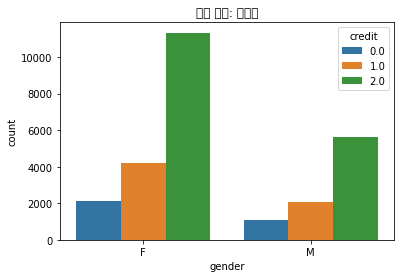

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot('gender',hue='credit', data=train)
plt.title('성별 분포: 신용도')
plt.show()

### 나이 데이터

출생일 데이터는 데이터 수집 당시부터 역으로 계산한다는데, 데이터 수집 당시가 언제지??  
아 그때 당시 나이니까 365를 나눠서 절대값 씌우면 됩니다.

In [19]:
train['age'] = abs(train['DAYS_BIRTH'] / 365).astype(int)
test['age'] = abs(test['DAYS_BIRTH'] / 365).astype(int)

In [20]:
print('가장 고령의 사용자: {} years'.format(train['age'].max()))
print('가장 어린 사용자: {} years'.format(train['age'].min()))
print('사용자 평균 나이: {:.1f} years'.format(train['age'].mean()))

가장 고령의 사용자: 68 years
가장 어린 사용자: 21 years
사용자 평균 나이: 43.2 years


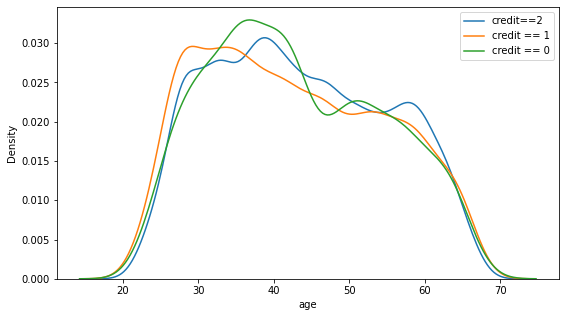

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(train[train['credit'] == 2.0]['age'], ax=ax)
sns.kdeplot(train[train['credit'] == 1.0]['age'], ax=ax)
sns.kdeplot(train[train['credit'] == 0.0]['age'], ax=ax)
plt.legend(['credit==2', 'credit == 1', 'credit == 0'])
plt.show()

그래프를 보면 신용등급 1의 경우 20-30대에 몰려 있고, 신용등급 0의 경우 35-40대에 머물러 있다

### 차량 소유 여부

In [22]:
train['car'].unique()

array(['N', 'Y'], dtype=object)

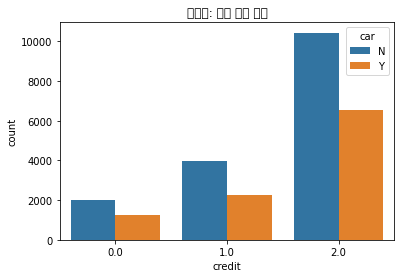

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot('credit',hue='car', data=train)
plt.title('신용도: 차량 소유 여부')
plt.show()

대체로 차량 소유 여부 비율이 비슷해보인다.

### 부동산 소유 여부

In [24]:
train['reality'].unique()

array(['N', 'Y'], dtype=object)

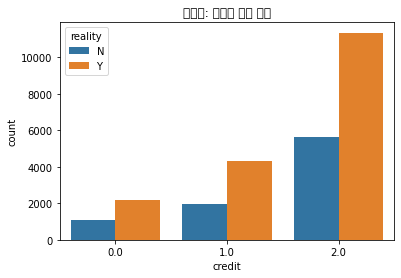

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot('credit',hue='reality', data=train)
plt.title('신용도: 부동산 소유 여부')
plt.show()

대체로 부동산 소유 여부 비율이 비슷해보인다.

### 자녀 수

In [26]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

자녀가 7명 이상은 좀 이상한데???  
7이상은 5명 이상으로 처리하자

In [27]:
train.loc[train.child_num > 5, 'child_num'] = 5

<AxesSubplot:xlabel='child_num', ylabel='count'>

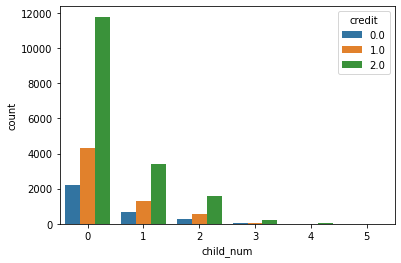

In [28]:
sns.countplot('child_num', hue='credit', data=train)

자녀수에 따라 신용도 차이가 크게 없어보인다.

### 연간 소득

In [29]:
train.income_total

index
0       202500.00
1       247500.00
2       450000.00
3       202500.00
4       157500.00
           ...   
26452   225000.00
26453   180000.00
26454   292500.00
26455   171000.00
26456    81000.00
Name: income_total, Length: 26457, dtype: float64

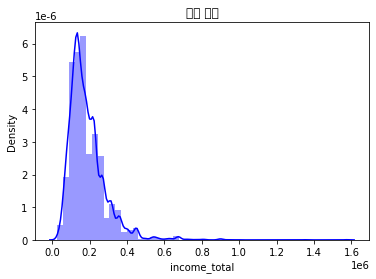

In [30]:
plt.figure(figsize=(6, 4))
sns.distplot(train.income_total, color='b')
plt.title('연간 소득')
plt.show()

그래프가 한쪽으로 쏠리는 현상이 나타났습니다.  
log변환을 사용해서 비대칭성을 없애주겠습니다. 

In [31]:
train["income_total"] = np.log1p(train["income_total"])
test["income_total"] = np.log1p(test["income_total"])

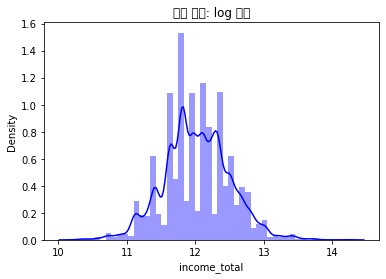

In [32]:
plt.figure(figsize=(6, 4))
sns.distplot(train.income_total, color='b')
plt.title('연간 소득: log 변환')
plt.show()

### 소득 분류

In [33]:
train.income_type.value_counts()

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

소득 분류는 어떻게 해석하면 좋을까??

In [34]:
train.loc[train.income_type=='Student']['age']

index
2990     51
3602     51
6223     24
8936     51
11646    33
21681    51
23119    33
Name: age, dtype: int64